# Character Social Network Analysis

In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import os
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# Load the model
nlp = spacy.load("en_core_web_sm")

# Increase the maximum length
nlp.max_length = 2500000

## Load the character data frame

In [4]:
# open csv file
character_df = pd.read_csv("characters_merged.csv")

In [5]:
# Clean up data frame

# Delete automatically generated column
del character_df["Unnamed: 0"]

# Add first name into a separate column
character_df['character_firstname'] = character_df['character_name'].apply(lambda x: x.split(' ', 1)[0])

# Replace 'Unknown' with np.nan
character_df["alias"].replace('Unknown',np.nan,inplace=True)

character_df["alias"] = character_df["alias"].astype(str)
character_df["alias"]

# Replace 'The' with empty string
character_df["alias"] = character_df["alias"].map(lambda x: x.replace("The ", ""))

# Remove a part of the Ramsay Bolton's aliases
character_df["alias"] = np.where(character_df['character_name']=='Ramsay Bolton',character_df['alias'].replace(re.compile(',Reek,Red Helm,Monster'), '', regex=True),character_df['alias'])

# Separate string by ',' and create a list
character_df['alias'] = character_df['alias'].str.split(',')


In [6]:
# Create book count column
books_count = character_df.groupby('character_name')['book'].size().reset_index(name='books_count')

# Merge the books_count with main dataframe
character_df = character_df.merge(books_count, on='character_name')

# Delete character duplicates to reduce computing load when replacing aliases
character_df = character_df.drop("book", axis=1)
character_df = character_df.drop_duplicates(subset=["character_name"], keep='last')

In [7]:
# change some character names for correct recognition
character_df.loc[character_df['character_name'].str.contains('Drogo'), 'character_name'] = 'Khal Drogo'
character_df.loc[character_df['character_name'].str.contains('Grey Worm'), 'character_firstname'] = 'Grey Worm'
character_df.loc[character_df['character_name'].str.contains('High Sparrow'), 'character_firstname'] = 'High Sparrow'
character_df.loc[character_df['character_name'].str.contains("Lord Commander's Raven"), 'character_firstname'] = "Lord Commander's Raven"
character_df.loc[character_df['character_name'].str.contains("Lord Sunglass"), 'character_firstname'] = "Lord Sunglass"
character_df.loc[character_df['character_name'].str.contains("Samwell Tarly"), 'alias'] = character_df.loc[character_df['character_name'].str.contains("Samwell Tarly"), 'alias'].apply(lambda x: ','.join(x))
character_df.loc[character_df['character_name'].str.contains("Benjen Stark"), 'alias'] = character_df.loc[character_df['character_name'].str.contains("Benjen Stark"), 'alias'].apply(lambda x: ','.join(x))
character_df.loc[character_df['character_name'].str.contains("Samwell Tarly"), "alias"] = "Sam :Sam,:Sam.:Sam?:Sam!:Ser Piggy:Lord of Ham:Lady Piggy:Piggy"
character_df.loc[character_df['character_name'].str.contains("Benjen Stark"), "alias"] = "Uncle Benjen:Ben Stark:Ben :Uncle Ben:Ben,:Ben.:Ben!:Ben?"
character_df.loc[character_df['character_name'].str.contains("Samwell Tarly"), 'alias'] = character_df.loc[character_df['character_name'].str.contains("Samwell Tarly"), 'alias'].str.split(":")
character_df.loc[character_df['character_name'].str.contains("Benjen Stark"), 'alias'] = character_df.loc[character_df['character_name'].str.contains("Benjen Stark"), 'alias'].str.split(":")


In [8]:
result = character_df[character_df['character_firstname'].duplicated(keep=False)]
pd.set_option('display.max_rows', None)
result

,character_name,alias,character_firstname,books_count
5,Aegon Frey,[nan],Aegon,4
10,Aegon I Targaryen,"[Aegon the Conqueror, Aegon the Dragonlord, Ae...",Aegon,5
11,Aemon (wildling),[nan],Aemon,1
13,Aemon Targaryen (Son of Maekar I),"[Aemon Targaryen, Uncle Maester]",Aemon,2
41,Alyn,[nan],Alyn,1
44,Alyn Haigh,[nan],Alyn,3
45,Alyn Orkwood,[Orkwood of Orkmont],Alyn,1
47,Alyn Stackspear,[nan],Alyn,2
59,Andrey Charlton,[nan],Andrey,1
60,Andrey Dalt,[Drey],Andrey,1


## Load books

In [9]:
# Get book names
path = "books_txt"
current_dir = os.getcwd()
abs_path = os.path.abspath(os.path.join(current_dir, path))

# Get all files in directory except temporary files
books = [book for book in os.listdir(abs_path) if os.path.isfile(os.path.join(path, book)) and not book.startswith('.')]
books.sort()

# Print all files
print(books)

['1_A_Game_Of_Thrones.txt', '2_A_Clash_Of_Kings.txt', '3_A_Storm_Of_Swords.txt', '4_A_Feast_For_Crows.txt', '5_A_Dance_With_Dragons.txt']


In [10]:
# Import function
from utils.my_functions import replace_word_in_file

In [11]:
# check presense of aliases before applying the function
book_text = open(f"{abs_path}/{books[0]}").read()
book_text.count("Dany")

0

In [12]:
# Iterate through books to replace aliases with full names

for book in books:
    book_path = f"{abs_path}/{book}"

    # iterate through character aliases and replace in text
    for i, row in character_df.iterrows():
        for alias in row['alias']:
            replace_word_in_file(book_path, alias, row['character_name'])

In [13]:
# Iterate through books to replace aliases with full names
for book in books:
    book_path = f"{abs_path}/{book}"
    replace_word_in_file(book_path, "Sam ", "Benjen Stark ")

In [14]:
# sanity check
book_text = open(f"{abs_path}/{books[0]}").read()
book_text.count("Dany")

0

## Named entity recognition

In [15]:
# Open modified text files and append to a list

modified_books = []

for book in books:
    book_text = open(f"{abs_path}/{book}").read()
    modified_books.append(book_text)

In [16]:
# Apply named entity recognition to books
book_docs = []
for index, book in enumerate(modified_books):
    print(f"started processing book {index+1}")
    book_doc = nlp(book)
    book_docs.append(book_doc)

started processing book 1
started processing book 2
started processing book 3
started processing book 4
started processing book 5


In [17]:
# Visualize identified entities
displacy.render(book_docs[0][0:1000], style="ent", jupyter=True)

## Get name entity list per sentence

In [18]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_docs[0].sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)


In [19]:
sent_entity_df.head()

,sentence,entities
0,"( , PROLOGUE, \n, We, should, start, back, ,, ...",[]
1,"(“, The, \n, wildlings, are, dead, ., ”, \n)",[]
2,"(“, Do, the, dead, frighten, you, ?, ”)",[]
3,"(Ser, Waymar, Royce, asked, with, just, the, h...",[Waymar Royce]
4,"(Gared, did, not, rise, to, the, bait, .)",[Gared]


In [20]:
# Import function
from utils.my_functions import filter_entity

In [35]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(5)

,sentence,entities,character_entities
3,"(Ser, Waymar, Royce, asked, with, just, the, h...",[Waymar Royce],[Waymar Royce]
4,"(Gared, did, not, rise, to, the, bait, .)",[Gared],[Gared]
23,"(Are, you, unmanned, by, the, dark, ,, Gared, ...",[Gared],[Gared]
48,"(Ser, Waymar, had, been, a, Sworn, Brother, of...","[Waymar, the Night’s Watch, less than half]",[Waymar]
103,"(“, What, do, you, think, might, have, killed,...",[Gared],[Gared]


In [36]:
main_characters = {"Brynden": "Brynden Tully", "Balon": "Balon IX Greyjoy", "Jeyne": "Jeyne Poole", "Jon": "Jon Snow",
                   "Lyanna": "Lyanna Stark", "Petyr": "Petyr Baelish", "Robert": "Robert I Baratheon",
                   "Tommen": "Tommen I Baratheon", "Tyrion": "Tyrion Lannister", "Viserys": "Viserys III Targaryen",
                   "Tywin": "Tywin Lannister"}

main_characters = pd.DataFrame.from_dict(main_characters, orient='index', columns=['full_name'])
main_characters = main_characters.reset_index()
main_characters = main_characters.rename(columns={'index':'first_name'})
main_characters

,first_name,full_name
0,Brynden,Brynden Tully
1,Balon,Balon IX Greyjoy
2,Jeyne,Jeyne Poole
3,Jon,Jon Snow
4,Lyanna,Lyanna Stark
5,Petyr,Petyr Baelish
6,Robert,Robert I Baratheon
7,Tommen,Tommen I Baratheon
8,Tyrion,Tyrion Lannister
9,Viserys,Viserys III Targaryen


In [37]:
# replace "nan" strings with NaN
character_df['alias'] = character_df['alias'].apply(lambda x: np.nan if (isinstance(x, list) and "nan" in x) else x)

In [38]:
# Import function
from utils.my_functions import replace_name

In [ ]:
# Apply replace_name function to data frame to replace first name of characters with a full name
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda lst: replace_name(lst, main_characters, character_df))

In [ ]:
# Jeyne Westerling for other books
Lyanna Mormont

## Create relationships

In [56]:
# Reset index from 0 to lenght of df
sent_entity_df_filtered = sent_entity_df_filtered.reset_index(drop=True)

In [78]:
# set a window size of 5 sentenses and create relationship pairs between characters
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+window_size, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [83]:
relationship_df = pd.DataFrame(relationships)
relationship_df.head(10)

,source,target
0,Waymar Royce,Gared
1,Gared,Waymar Royce
2,Waymar Royce,Gared
3,Gared,Waymar Royce
4,Gared,Waymar Royce
5,Waymar Royce,Gared
6,Gared,Waymar Royce
7,Waymar Royce,Gared
8,Gared,Waymar Royce
9,Gared,Waymar Royce


In [84]:
# Sort the pairs
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)

In [88]:
# count the occurences of pair of characters and store it in value column
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [92]:
# sort data frame by value column and display most frequently encountered relationships
relationship_sort = relationship_df.sort_values(by='value', ascending=False)
relationship_sort.head(15)

,source,target,value
29,Ned Stark,Robert I Baratheon,1519
200,Ned Stark,Petyr Baelish,568
210,Grenn,Jon Snow,335
66,Benjen Stark,Jon Snow,327
33,Daenerys I Targaryen,Khal Drogo,265
68,Arya Stark,Sansa Stark,265
328,Jon Snow,Samwell Tarly,255
7,Bran Stark,Jon Snow,236
23,Jon Snow,Ned Stark,229
85,Arya Stark,Jeyne Poole,223


## Visualization of character relationships

In [93]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

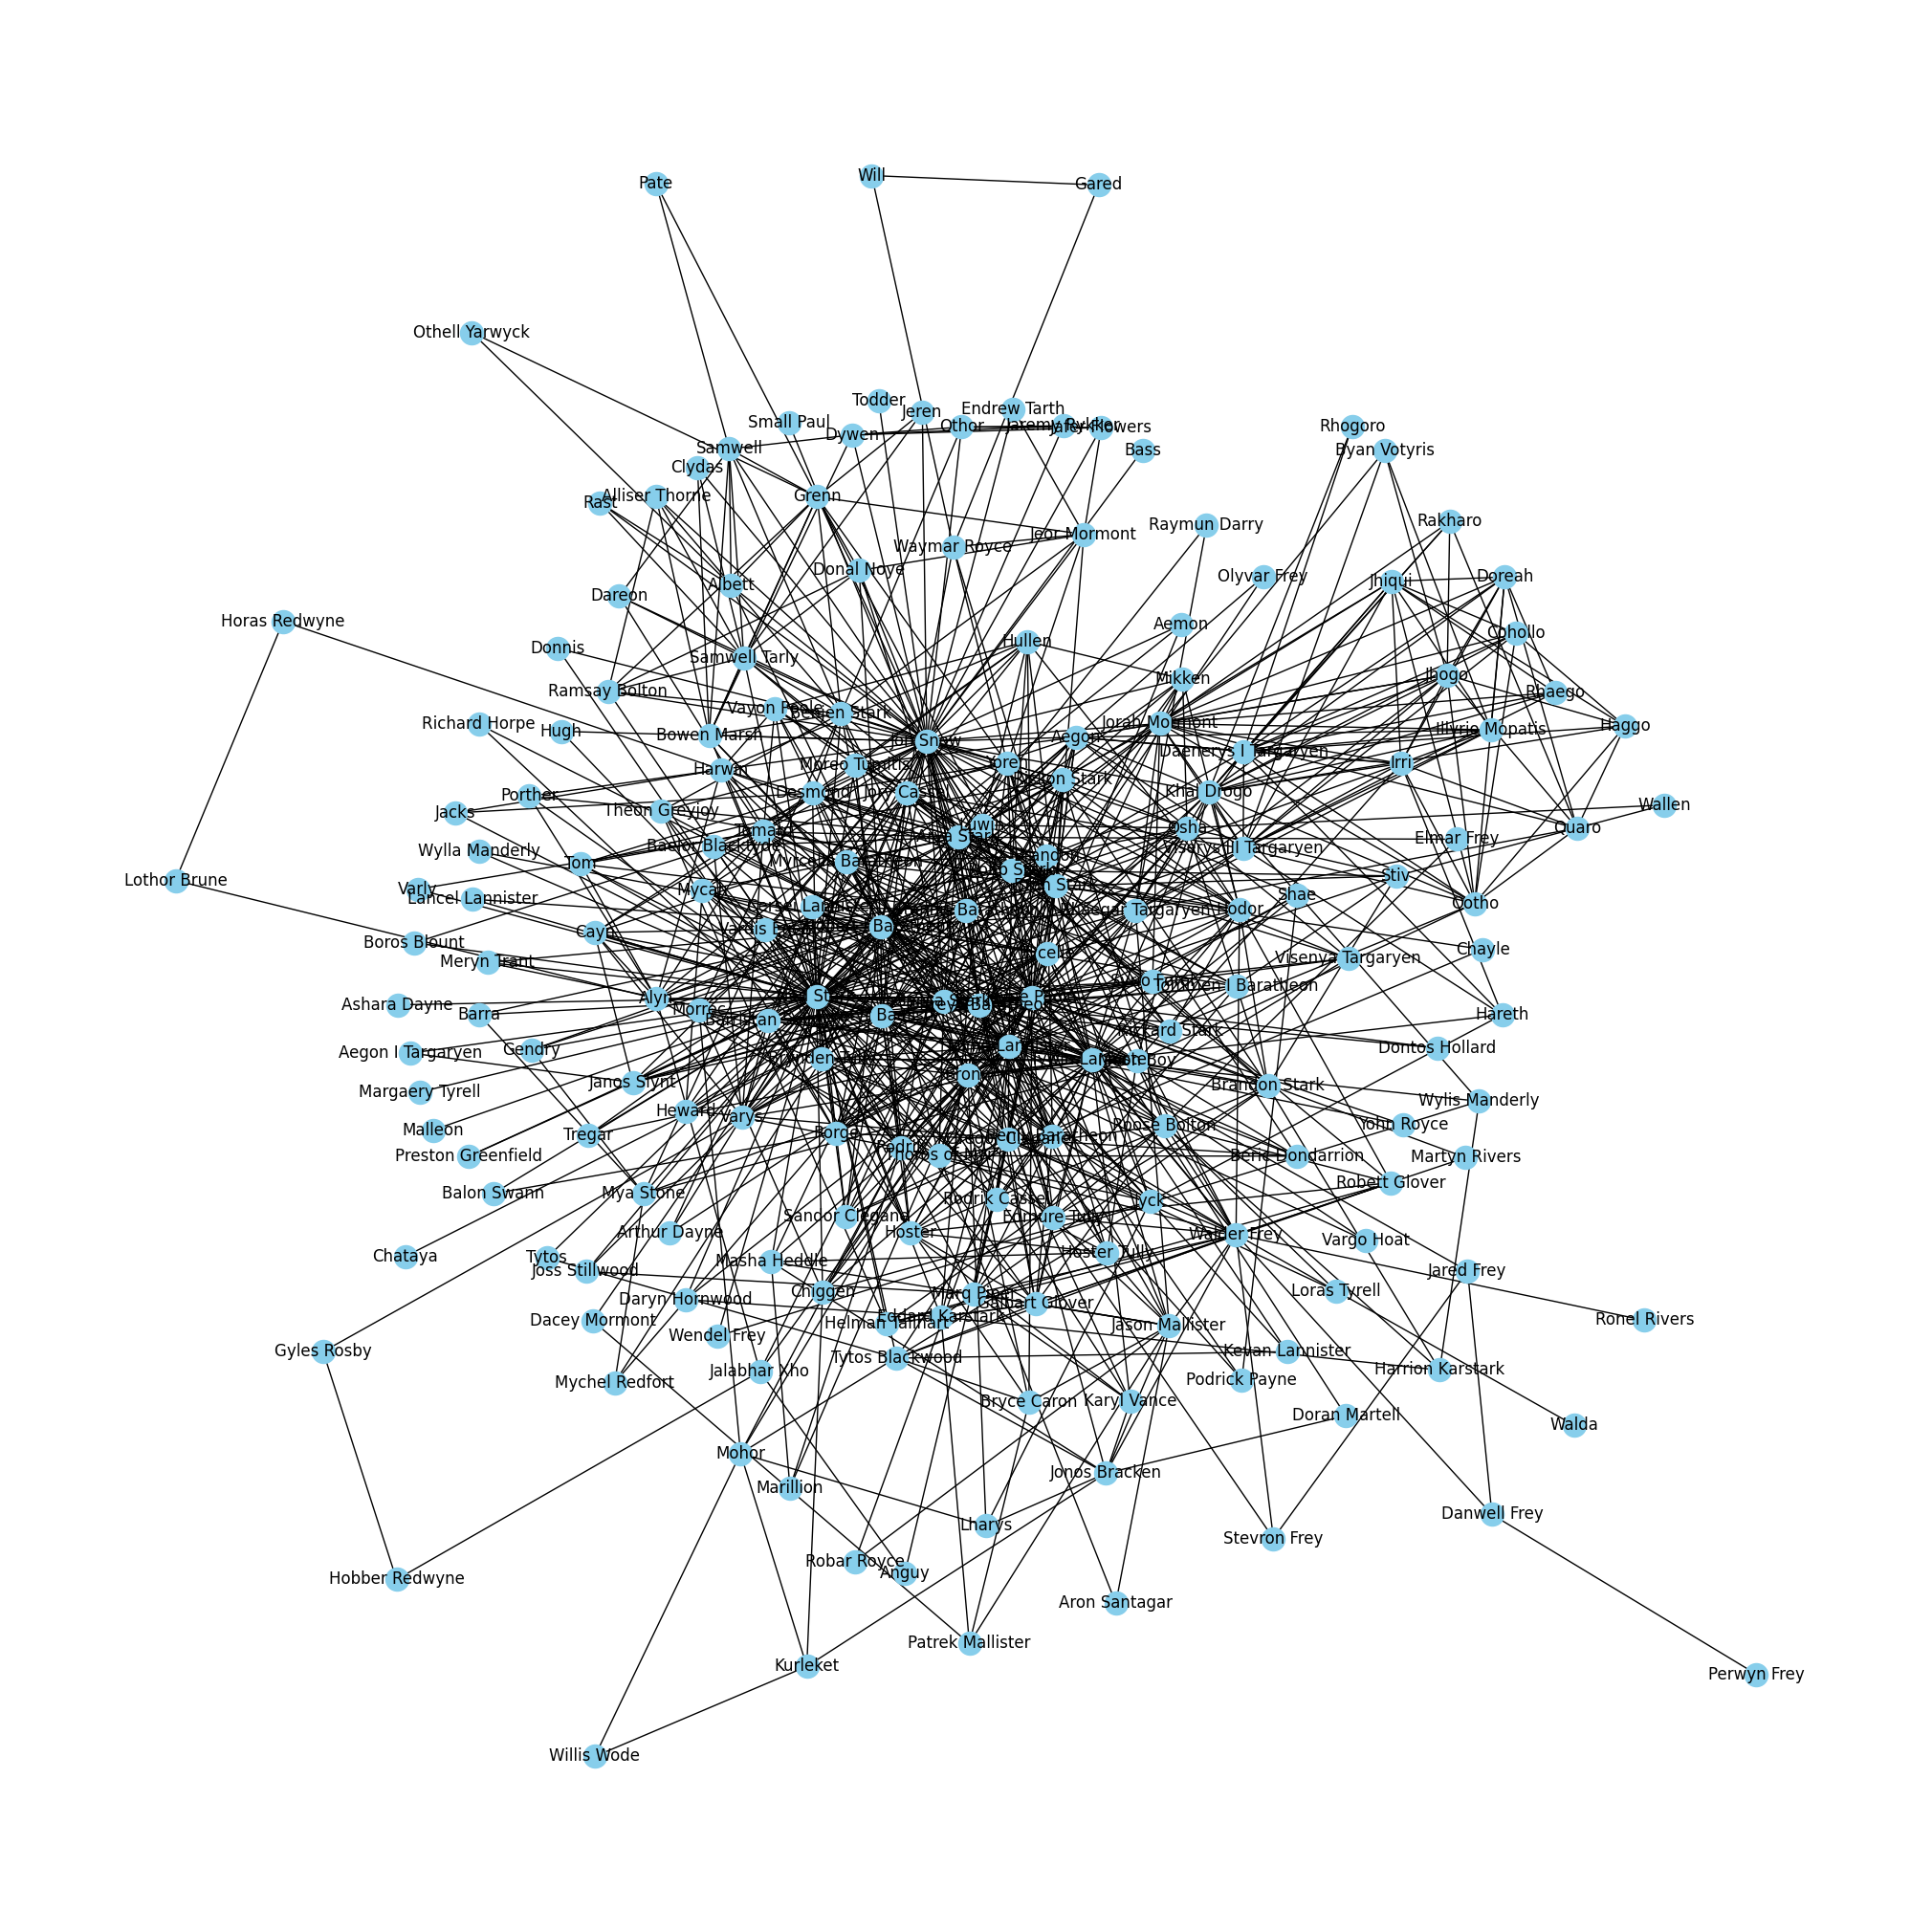

In [95]:
plt.figure(figsize=(20,20))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [106]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.toggle_physics(True)
net.show_buttons(filter_=['physics'])
net.show("got.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [107]:
dict(G.degree)


{'Gared': 2,
 'Waymar Royce': 6,
 'Will': 2,
 'Robert I Baratheon': 58,
 'Bran Stark': 45,
 'Jeyne Poole': 47,
 'Jon Snow': 64,
 'Jory Cassel': 17,
 'Robb Stark': 23,
 'Hullen': 12,
 'Harwin': 13,
 'Rickon Stark': 19,
 'Desmond': 16,
 'Ned Stark': 91,
 'Sansa Stark': 40,
 'Brynden Tully': 17,
 'Viserys III Targaryen': 17,
 'Illyrio Mopatis': 10,
 'Khal Drogo': 25,
 'Daenerys I Targaryen': 18,
 'Rhaegar Targaryen': 23,
 'Aegon': 19,
 'Rhogoro': 2,
 'Theon Greyjoy': 7,
 'Cersei Lannister': 18,
 'Jaime Lannister': 46,
 'Brandon': 19,
 'Rickard Stark': 8,
 'Tywin Lannister': 45,
 'Benjen Stark': 18,
 'Arya Stark': 42,
 'Joffrey I Baratheon': 33,
 'Luwin': 11,
 'Ashara Dayne': 1,
 'Myrcella Baratheon': 10,
 'Tommen I Baratheon': 8,
 'Donnis': 2,
 'Rodrik': 21,
 'Arthur Dayne': 3,
 'Barristan Selmy': 17,
 'Mikken': 9,
 'Hodor': 19,
 'Stannis Baratheon': 21,
 'Renly Baratheon': 15,
 'Petyr Baelish': 40,
 'Chayle': 2,
 'Sandor Clegane': 9,
 'Rorge': 16,
 'Jorah Mormont': 22,
 'Irri': 14,
 'Jhi